# **Landslide Predictor**

program ini berfungsi sebagai prediksi kejadian longsor dari suatu daerah

# **Instalasi**

In [2]:
system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
system('sudo apt-get update')
system('sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev')

In [ ]:
install.packages("raster")
install.packages("rgdal")
install.packages("sf")
install.packages("rgeos")
install.packages("maptools")
install.packages("readr")
install.packages("pROC")
install.packages("kernlab")
install.packages("caret")
install.packages("glmnet")

In [ ]:
# import library
library(raster)
library(rgdal)
library(sf)
library(rgeos)
library(maptools)
library(readr)
library(pROC)
library(kernlab)
library(caret)
library(glmnet)

# **Load data**

In [ ]:
# load data-data
citra <- stack("citra_magelang.tif")
dem <- raster("dem_magelang.tif")
jenis_tanah <- readOGR('tanah_magelang.shp')
koordinat_longsor <- read_csv("koordinat_longsor.csv")

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded ellps WGS 84 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs”
Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum WGS_1984 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs”
Warning message in showSRID(wkt2, "PROJ"):
“Discarded ellps WGS 84 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs +type=crs”
Warning message in showSRID(wkt2, "PROJ"):
“Discarded datum World Geodetic System 1984 in Proj4 definition”


OGR data source with driver: ESRI Shapefile 
Source: "/content/tanah_magelang.shp", layer: "tanah_magelang"
with 21 features
It has 14 fields
Integer64 fields read as strings:  FID_ 


Warning message in readOGR("tanah_magelang.shp"):
“Z-dimension discarded”
Rows: 795 Columns: 3

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): lon, lat, longsor


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



# **Data preprocessing**

In [ ]:
# global variable
crs=CRS("+proj=longlat +datum=WGS84")

In [ ]:
ndvi <- (citra[[4]]-citra[[3]])/(citra[[4]]+citra[[3]])
ndmi <- (citra[[4]]-citra[[5]])/(citra[[4]]+citra[[5]])
bsi <- ((citra[[3]]+citra[[5]])-(citra[[4]])+citra[[1]])/((citra[[3]]+citra[[5]])+(citra[[4]])+citra[[1]])

In [ ]:
ndvi<-projectRaster(ndvi, crs=crs)
ndmi<-projectRaster(ndmi, crs=crs)
bsi<-projectRaster(bsi, crs=crs)

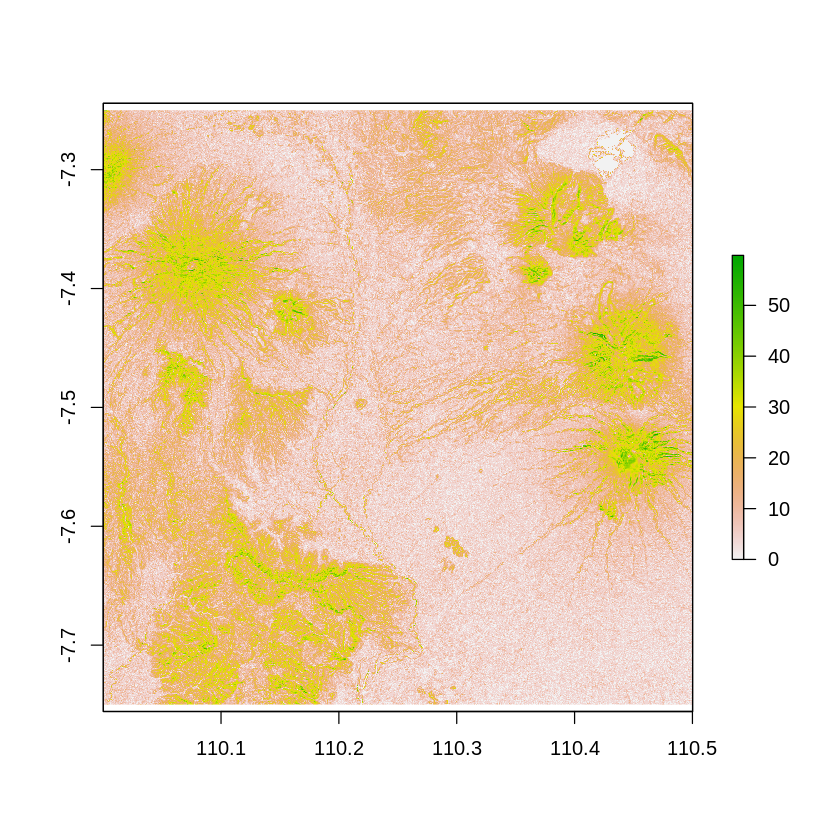

In [ ]:
#menghitung kelerengan
slope <- terrain(dem, opt = 'slope', unit = 'degrees')
plot(slope)

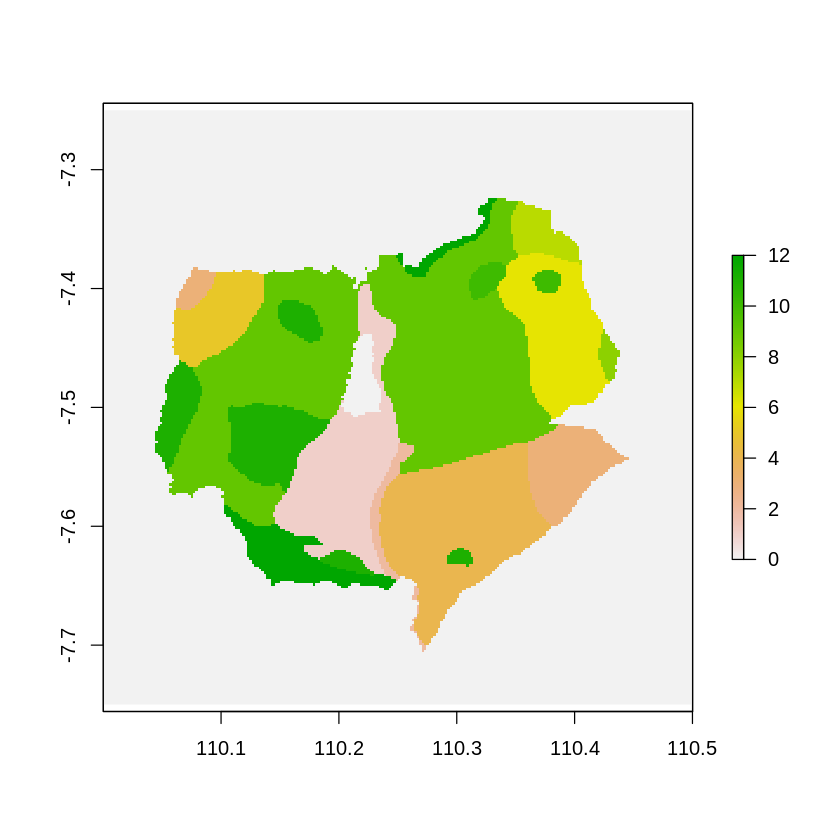

In [ ]:
# membuat raster jenis tanah
tanah.proj<- spTransform(jenis_tanah,crs )
t <- raster(xmn=110.0001, xmx=110.5001, ymn=-7.75, ymx=-7.25, res=c(0.002,0.002), crs=crs)
tanah <- rasterize(x = tanah.proj, y = t, field = jenis_tanah@data$ID)
tanah[is.na(tanah[])] <- 0 
plot(tanah)

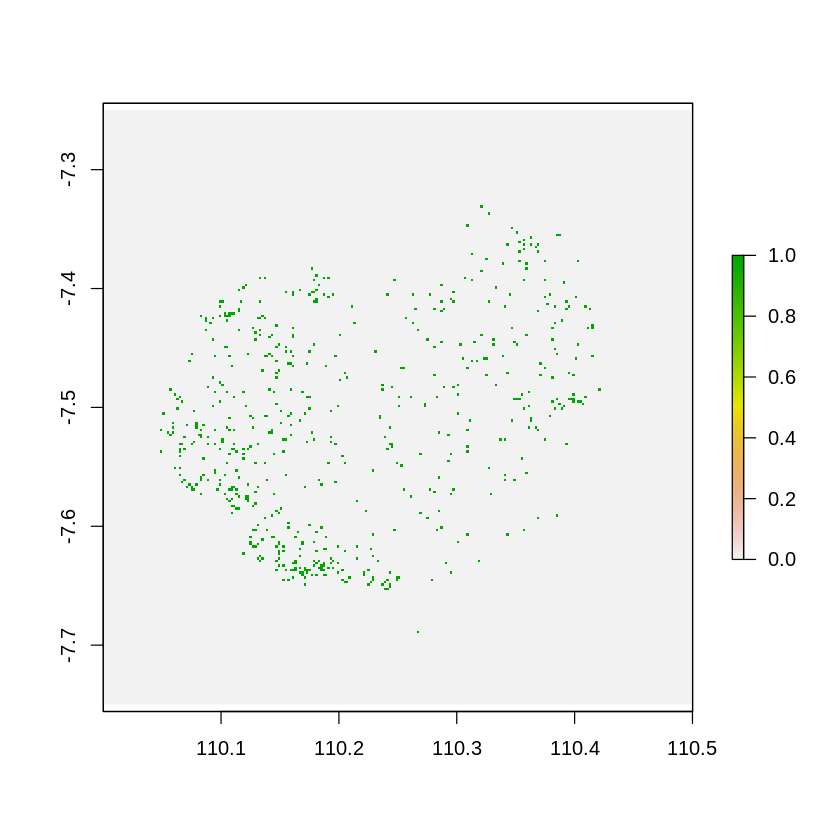

In [ ]:
# membuat raster persebaran
x <- raster(xmn=110.0001, xmx=110.5001, ymn=-7.75, ymx=-7.25, res=c(0.002,0.002), crs=crs)
longsor <- rasterize(koordinat_longsor[, c('lon', 'lat')], x, koordinat_longsor[, 'longsor'])
longsor[is.na(longsor[])] <- 0 

plot(longsor)

In [ ]:
# menseragamkan extent
getMaxExtent <- function(rasters) {
  extents <- sapply(rasters, FUN = function(x) {
    raster::extent(x)
  })
  r <- raster(ext = extents[[1]], nrows = rasters[[1]]@nrows, ncols = rasters[[1]]@ncols)
  max_extent <- sapply(extents, FUN = function(x) {
    r <<- raster::extend(r, x)
  })
  raster::extent(r)
}

In [ ]:
rasters <- list(ndvi,ndmi,bsi,slope, tanah, longsor)
ext<-getMaxExtent(rasters)
ext

class      : Extent 
xmin       : 110.0001 
xmax       : 110.5002 
ymin       : -7.750089 
ymax       : -7.249986 

In [ ]:
ndvi<-setExtent(ndvi, ext, keepres=FALSE, snap=FALSE)
ndmi<-setExtent(ndmi, ext, keepres=FALSE, snap=FALSE)
bsi<-setExtent(bsi, ext, keepres=FALSE, snap=FALSE)
slope<-setExtent(slope, ext, keepres=FALSE, snap=FALSE)
tanah<-setExtent(tanah, ext, keepres=FALSE, snap=FALSE)
longsor<-setExtent(longsor, ext, keepres=FALSE, snap=FALSE)

In [ ]:
# resample raster
longsor <- raster::disaggregate(longsor, fact=9, method='')
tanah <- raster::disaggregate(tanah, fact=9, method='')
ndvi <- raster::resample(ndvi, tanah, method='bilinear')
ndmi <- raster::resample(ndmi, tanah, method='bilinear')
bsi <- raster::resample(bsi, tanah, method='bilinear')
slope <- raster::resample(slope, tanah, method='bilinear')

# **transformasi data menjadi dataframe**

In [ ]:
# membuat dataframe
raster.analisis <- stack(longsor, ndvi, ndmi, bsi, slope, tanah)
point <- rasterToPoints(raster.analisis)
df<-as.data.frame(point)

In [ ]:
# membuat training data dan test data
yes <- na.omit(df[ sample(which (df$layer.1 == 1 && df$layer. == 1) ,700), ])
no <- na.omit(df[ sample(which (df$layer.1 != 1) , 700), ])


train <- rbind(yes, no)
train <- train[sample(nrow(train)),]

xtabs(train$`layer.1`~train$`layer.5`)

N_FILES <- length(train[,1])
SPLT <- 0.8 #80% train
b <- floor(SPLT*N_FILES)
train.data <- train[1:b,]
test.data <- train[(b+1):N_FILES,]



train$layer.5
  0   1   2   3   4   5   6   7   9  10  11  12 
  9  50   6   6  36  36  57  20 277   4  83 116 

# **Membuat model**

In [ ]:
# membuat model
p <- model.matrix(layer.1 ~ layer.2+layer.3+layer.4+slope+as.factor(layer.5), train.data)[,-1]
y <- train.data$layer.1

xtabs(layer.1 ~ layer.5, data = train.data)
xtabs(layer.1 ~ layer.5, data = test.data)

set.seed(123) 
cv.lasso <- cv.glmnet(p, y, alpha = 1, family = "binomial")
# Fit the final model on the training data
model <- glmnet(p, y, alpha = 1, family = "binomial",
                lambda = cv.lasso$lambda.min)

coef(cv.lasso, cv.lasso$lambda.min)

layer.5
  0   1   2   3   4   5   6   7   9  10  11  12 
  6  39   5   5  29  30  45  18 232   3  69 100 

layer.5
 0  1  2  3  4  5  6  7  9 10 11 12 
 3 11  1  1  7  6 12  2 45  1 14 16 

16 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)          -3.42456109
layer.2               .         
layer.3              -1.66183433
layer.4              -1.97706446
slope                 0.02162799
as.factor(layer.5)1   4.45769670
as.factor(layer.5)2   8.20536683
as.factor(layer.5)3   3.01789416
as.factor(layer.5)4   3.72567529
as.factor(layer.5)5   5.24203967
as.factor(layer.5)6   4.63886291
as.factor(layer.5)7   5.41593677
as.factor(layer.5)9   4.82673924
as.factor(layer.5)10  3.41639521
as.factor(layer.5)11  5.22406859
as.factor(layer.5)12  6.56852873

# **test model**

In [ ]:
# performa model
test <- model.matrix(layer.1 ~ layer.2+layer.3+layer.4+slope+as.factor(layer.5), test.data)[,-1]
probabilities <- model %>% predict(newx = test)
predicted.classes <- ifelse(probabilities > 0.5, 1, 0)
observed.classes <- test.data$layer.1

confmat <- confusionMatrix(as.factor(observed.classes),as.factor(predicted.classes), positive='1')
confmat

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 116  44
         1  15 104
                                          
               Accuracy : 0.7885          
                 95% CI : (0.7359, 0.8349)
    No Information Rate : 0.5305          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5808          
                                          
 Mcnemar's Test P-Value : 0.0002671       
                                          
            Sensitivity : 0.7027          
            Specificity : 0.8855          
         Pos Pred Value : 0.8739          
         Neg Pred Value : 0.7250          
             Prevalence : 0.5305          
         Detection Rate : 0.3728          
   Detection Prevalence : 0.4265          
      Balanced Accuracy : 0.7941          
                                          
       'Positive' Class : 1               
                              

In [ ]:
# prediksi
df[is.na(df)] <- 0
var <- model.matrix(layer.1 ~ layer.2+layer.3+layer.4+slope+as.factor(layer.5), df)[,-1]
prob <- model %>% predict(var, type = "response")

final_output <- cbind(df[1:2],prob)
final <- rasterFromXYZ(final_output)

plot(final)

proj4string(final) = crs

writeRaster(final, filename = 'final.tif', overwrite=TRUE)